In [1]:
import matplotlib.pyplot as plt
import itertools
import json
import numpy as np
from pylhe import read_lhe_with_attributes, read_num_events
import itertools
import json
import math
import vector
import mplhep as hep
from scipy.optimize import curve_fit
import os
import glob
import pandas as pd

In [2]:
file_path = r"C:\Users\Arnull\OneDrive - The University of Manchester\Documents\MPHYS Poject\sem 1 code stuff\week_9\combined_helicity_data.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
triboson_mass = data["Triboson Mass"].to_numpy()
muon_polar_angle = data["Muon Polar Angle"].to_numpy()
electron_neutrino_polar_angle = data["Electron Neutrino Polar Angle"].to_numpy()
electron_polar_angle = data["Electron Polar Angle"].to_numpy()


In [4]:
def z_helicity_function(cos_theta, fL, fR, f0):
    cv = -1/2 + 2* np.sin(0.23152)**2
    ca = -1/2
    alpha = (2*cv*ca)/ (cv**2+ca**2)
    """The fitting function with the provided equation."""
    term1 = (3/8) * fL * (1 + 2 * alpha * cos_theta + cos_theta**2)
    term2 = (3/8) * fR * (1 + cos_theta**2 - 2 * alpha * cos_theta)
    term3 = (3/4) * f0 * (1 - cos_theta**2)
    return term1 + term2 + term3

def w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 - cos_theta)**2
    term2 = (3/8) * fR * (1 + cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

def anti_w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 + cos_theta)**2
    term2 = (3/8) * fR * (1 - cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

In [5]:
def calculate_helicity_fractions_for_bins(data, boson_type):
    

    # Filter out NaN and infinite values
    valid_data = data[np.isfinite(data)]
    cos_theta_data = np.cos(valid_data)
    cos_theta_bins = np.linspace(-1, 1, 50)

    # Calculate histogram values without plotting
    hist_values, bins = np.histogram(cos_theta_data, bins=cos_theta_bins, 
                                     weights=np.ones(len(cos_theta_data)) / (100000* (cos_theta_bins[1] - cos_theta_bins[0])))

    # Select helicity function based on boson type
    if boson_type == "Z":
        helicity_function = z_helicity_function
    elif boson_type == "W+":
        helicity_function = w_helicity_function
    elif boson_type == "W-":
        helicity_function = anti_w_helicity_function

    # Fitting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    initial_guess = [0.5, 0.1, 0.1]
    bounds = (0, 1)
    errors = np.sqrt(hist_values)

    popt, pcov = curve_fit(helicity_function, bin_centers, hist_values, sigma=errors, p0=initial_guess, bounds=bounds)
    total = sum(popt)
    normalized_popt = popt / total if total > 0 else popt 
    perr = np.sqrt(np.diag(pcov))
    return normalized_popt,  perr

In [6]:
def splitting_function(sorted_leptons):
    """
    Splits the sorted_leptons data into 35 bins of approximately equal size.

    Parameters:
    sorted_leptons (list or array): Input data sorted in ascending order.

    Returns:
    list of bins: A list containing 35 bins as separate sublists.
    """
    # Determine the number of elements in each bin
    bin_size = len(sorted_leptons) // 35
    # Create the bins using slicing
    bins = [sorted_leptons[i * bin_size : (i + 1) * bin_size] for i in range(35)]
    
    # Check for leftover elements (if the data cannot be divided evenly)
    leftover = len(sorted_leptons) % 35
    if leftover:
        bins[-1].extend(sorted_leptons[-leftover:])  # Add the leftovers to the last bin

    return bins

In [7]:
def plot_helicity_fraction_steps_with_errors(muon_bin_fractions, com_energies, errors, boson_type, bin_size=100000):
    """
    Plot the helicity fractions as steps for each bin with horizontal error bars.

    Parameters:
    - muon_bin_fractions: List of lists, where each sublist contains three helicity fractions for a bin.
    - com_energies: Array of center-of-mass energies corresponding to the data.
    - errors: List of lists, where each sublist contains three errors for a bin.
    - bin_size: Number of entries per bin (default: 100,000).
    """
   
    # Custom labels for the helicity fractions
    labels = ["$f_L$", "$f_R$", "$f_0$"]
    colors = ["blue", "orange", "green"]  # Colors for the step lines

    # Create bin ranges based on com_energies
    num_bins = len(com_energies) // bin_size
    bin_edges = [
        (com_energies[i * bin_size], com_energies[min((i + 1) * bin_size - 1, len(com_energies) - 1)])
        for i in range(num_bins)
    ]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

    # Loop through each helicity fraction index (0, 1, 2) and plot them as steps
    for i in range(3):
        step_x = []  # X coordinates for the step plot
        step_y = []  # Y coordinates for the step plot
        bin_centers = []  # Centers of bins for error bars
        error_values = []  # Error values for this helicity fraction

        for j, (start, end) in (enumerate(bin_edges)):
            # Add points for the start and end of each bin
            step_x.extend([start, end])
            step_y.extend([muon_bin_fractions[j][i], muon_bin_fractions[j][i]])

            # Calculate the bin center and add it to the list
            bin_centers.append((start + end) / 2)
            error_values.append(errors[j][i])

        # Plot the step outline
        ax.step(
            step_x,
            step_y,
            where='post',
            color=colors[i],
            label=labels[i],
            linewidth=2
        )

    



    # Adjust title and text positions
    ax.set_title(
        f"Helicity Fractions for {boson_type} boson as a Function of Partonic COM Energy",
        fontsize=14, pad=60  # Increase pad to add space between title and plot
    )
    

    
    # Adjust spacing between elements
    plt.subplots_adjust(top=0.75)  # Lower the top of the plot area to add more space for the title and text
    
    # Customize the plot
    ax.set_xlabel("Partonic COM Energy [GeV]", loc='center')
    ax.set_ylabel("Helicity Fraction")
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for the y-axis
    
        # Define save path relative to the current directory, with a sanitized decay product



    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

In [19]:
def plot_helicity_fraction_steps_with_errors_four_bins(muon_bin_fractions, com_energies, errors, boson_type, bin_size=100000):
    """
    Plot the helicity fractions as steps for each bin with horizontal error bars.
    Excludes the last bin.

    Parameters:
    - muon_bin_fractions: List of lists, where each sublist contains three helicity fractions for a bin.
    - com_energies: Array of center-of-mass energies corresponding to the data.
    - errors: List of lists, where each sublist contains three errors for a bin.
    - boson_type: The type of boson being analyzed.
    - bin_size: Number of entries per bin (default: 100,000).
    """

    # Custom labels for the helicity fractions
    labels = ["$f_L$", "$f_R$", "$f_0$"]
    colors = ["blue", "orange", "green"]  # Colors for the step lines

    # Create bin ranges based on com_energies
    num_bins = len(com_energies) // bin_size
    bin_edges = [
        (com_energies[i * bin_size], com_energies[min((i + 1) * bin_size - 1, len(com_energies) - 1)])
        for i in range(num_bins)
    ]

    # Limit to bins 1 to 34 (exclude the last bin)
    bin_edges = bin_edges[:34]
    muon_bin_fractions = muon_bin_fractions[:34]
    errors = errors[:34]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

    # Loop through each helicity fraction index (0, 1, 2) and plot them as steps
    for i in range(3):
        step_x = []  # X coordinates for the step plot
        step_y = []  # Y coordinates for the step plot
        bin_centers = []  # Centers of bins for error bars
        error_values = []  # Error values for this helicity fraction

        for j, (start, end) in enumerate(bin_edges):
            # Add points for the start and end of each bin
            step_x.extend([start, end])
            step_y.extend([muon_bin_fractions[j][i], muon_bin_fractions[j][i]])

            # Calculate the bin center and add it to the list
            bin_centers.append((start + end) / 2)
            error_values.append(errors[j][i])

        # Plot the step outline
        ax.step(
            step_x,
            step_y,
            where='post',
            color=colors[i],
            label=labels[i],
            linewidth=2
        )

        # Plot the error bars
        ax.errorbar(
            bin_centers,
            [muon_bin_fractions[j][i] for j in range(len(bin_centers))],
            yerr=error_values,
            fmt='.',
            color=colors[i],
            capsize=3, markersize = 0.1
        )

    # Title and labels
    ax.set_title(
        f"Helicity Fractions for {boson_type} Boson as a Function of Partonic COM Energy",
        fontsize=14
    )
    ax.set_xlabel("Partonic COM Energy [GeV]", fontsize=12)
    ax.set_ylabel("Helicity Fraction", fontsize=12)

    # Grid and legend
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(fontsize=12)

    sorted_energies = np.sort(com_energies)
    energy_bins = splitting_function(sorted_energies)
    ax.set_xlim([energy_bins[0][0], energy_bins[33][-1]])

    # Adjust spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


In [9]:
def charlies_badboy_funct(lepton_four_momentum, boson_type, partonic_four_vec, cross_section, beam_energy, num_events, decay_product):
    partonic_com = invariant_mass_calculation_function(partonic_four_vec)
    decay_angles = find_polar_angle(lepton_four_momentum)
    indices = np.argsort(partonic_com)
    sorted_com_energy = partonic_com[indices]
    sorted_angles = decay_angles[indices]
    bin_1, bin_2, bin_3, bin_4, bin_5 = splitting_function(sorted_angles)
    helicity_fractions_array = [calculate_helicity_fractions_for_bins(i,boson_type, cross_section)[0] for i in [bin_1, bin_2, bin_3, bin_4, bin_5]]
    helicity_fraction_errors = [calculate_helicity_fractions_for_bins(i,boson_type, cross_section)[1] for i in [bin_1, bin_2, bin_3, bin_4, bin_5]]
    plot_helicity_fraction_steps_with_errors(helicity_fractions_array, sorted_com_energy, helicity_fraction_errors, boson_type, beam_energy, cross_section, decay_product)
    return



In [10]:
def plot_helicity_fractions(com_energies, lepton_angles, boson_type):
    indices = np.argsort(com_energies)
    sorted_com = com_energies[indices]
    sorted_angles = lepton_angles[indices]
    lepton_bins = splitting_function(sorted_angles)
    helicity_fractions_array = [calculate_helicity_fractions_for_bins(i,boson_type)[0] for i in lepton_bins]
    helicity_fractions_array_e = [calculate_helicity_fractions_for_bins(i,boson_type)[1] for i in lepton_bins]
    plot_helicity_fraction_steps_with_errors(helicity_fractions_array,sorted_com,helicity_fractions_array_e, boson_type)
    return

def plot_helicity_fractions_one_less_bin(com_energies, lepton_angles, boson_type):
    indices = np.argsort(com_energies)
    sorted_com = com_energies[indices]
    sorted_angles = lepton_angles[indices]
    lepton_bins = splitting_function(sorted_angles)
    helicity_fractions_array = [calculate_helicity_fractions_for_bins(i,boson_type)[0] for i in lepton_bins]
    helicity_fractions_array_e = [calculate_helicity_fractions_for_bins(i,boson_type)[1] for i in lepton_bins]
    plot_helicity_fraction_steps_with_errors_four_bins(helicity_fractions_array,sorted_com,helicity_fractions_array_e, boson_type)
    return

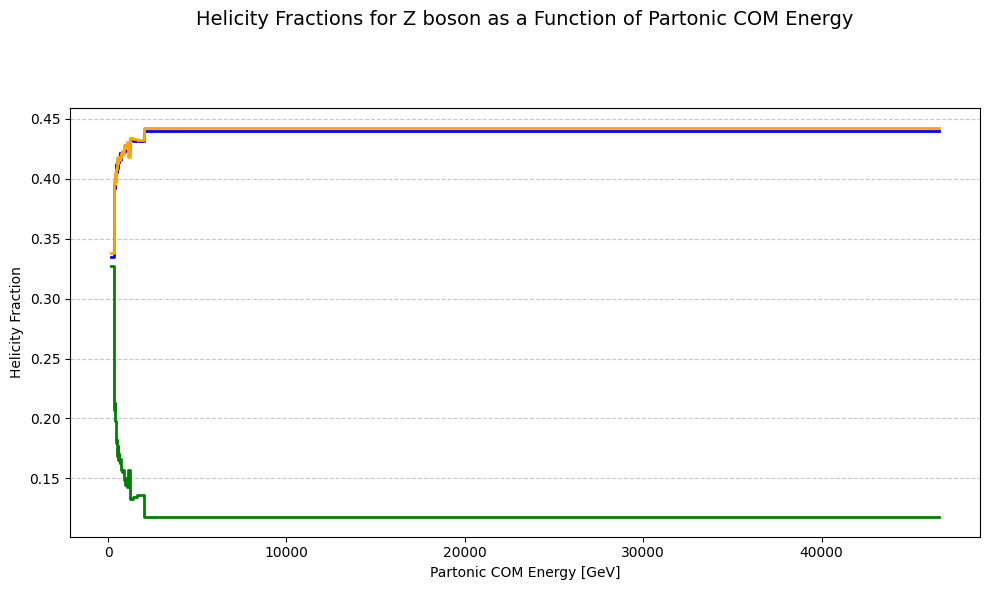

In [11]:
plot_helicity_fractions(triboson_mass, muon_polar_angle,"Z")

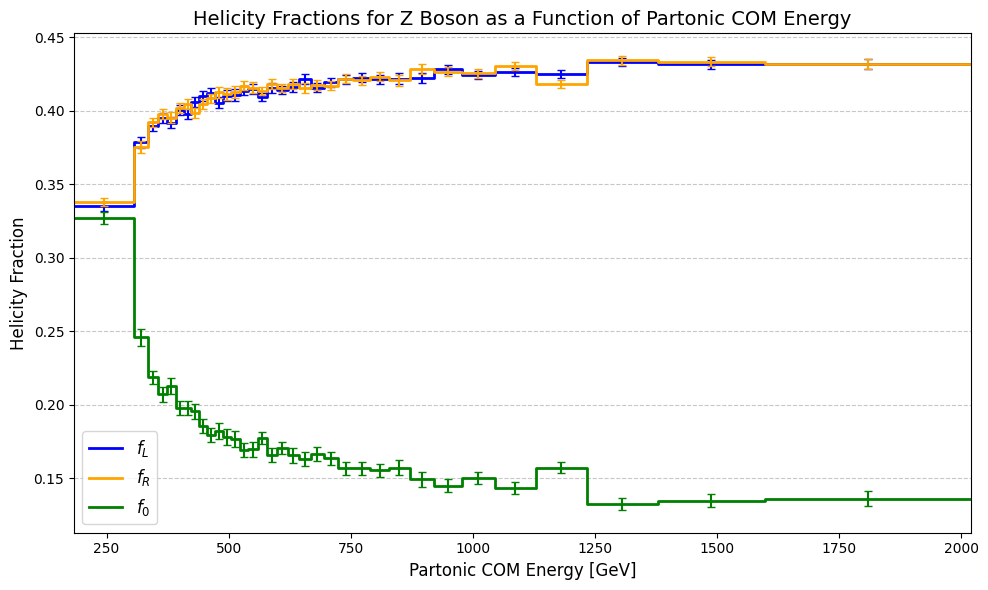

In [20]:
plot_helicity_fractions_one_less_bin(triboson_mass, muon_polar_angle,"Z")

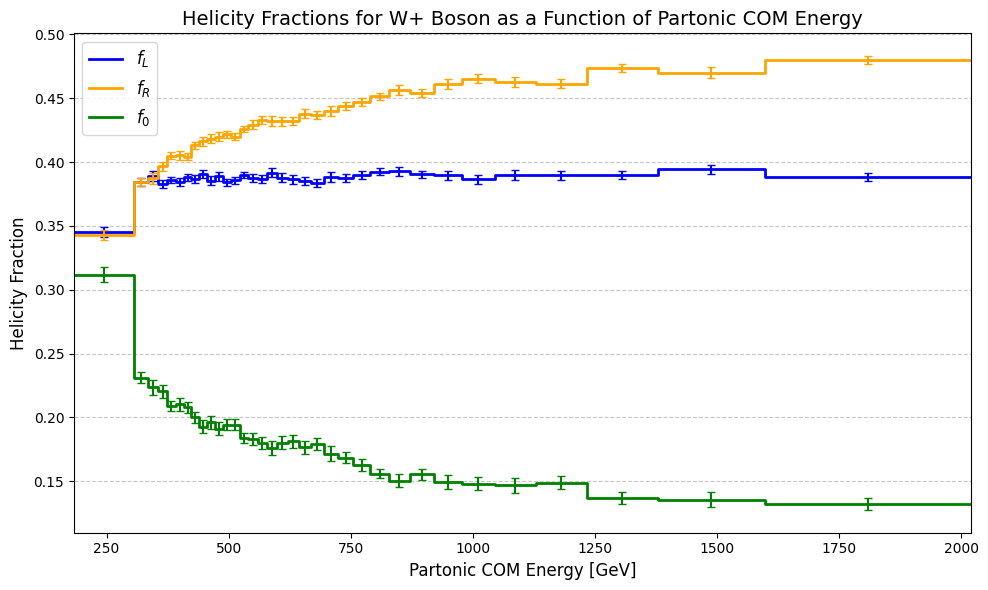

In [13]:
plot_helicity_fractions_one_less_bin(triboson_mass, electron_neutrino_polar_angle,"W+")

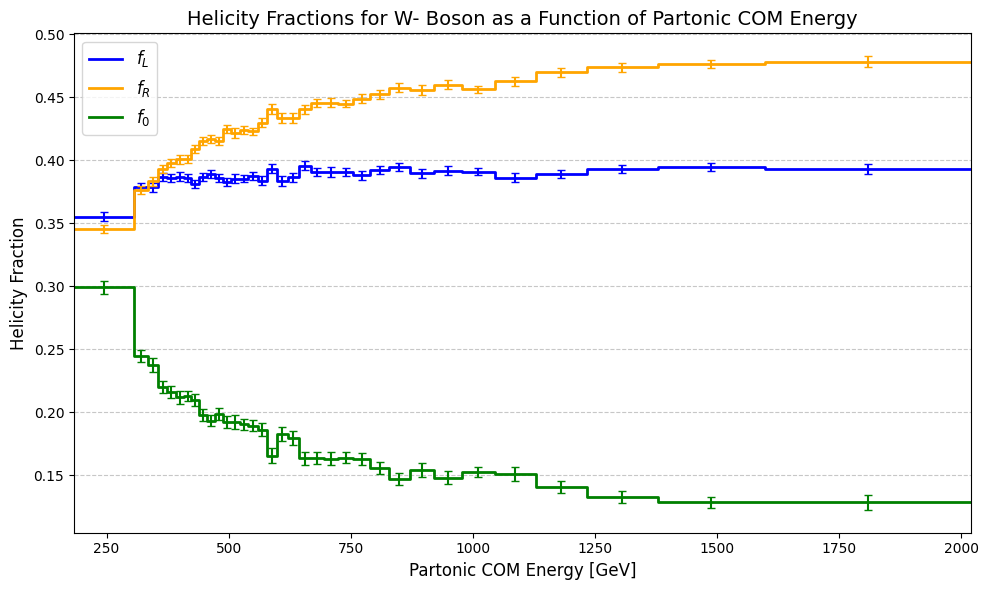

In [14]:
plot_helicity_fractions_one_less_bin(triboson_mass, electron_polar_angle,"W-")